# Victorian Water Measurement Information System
> Trying to simply get access via REST to data in https://data.water.vic.gov.au.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, hydstra]
- author: J-M & Andrew Freebairn


# About

Trying to retrieve time series or streamflow measurements via a REST API. Or anything that works for that matter.

This builds on work done by my colleague [Andrew Freebairn](https://github.com/fre171csiro), which really gave me a leg up.


# Web API: which one?

I am not a regular user of online data. Whenever I really needed to fetch data from an online service, this tended to be an experience where reverting back to using a Web GUI with a "download data" button the path of least pain.

Before writing this section I got confused, trying to use [kiwis-pie](https://github.com/amacd31/kiwis_pie) to retrieve data from the VIC data web site. Which is not suitable. I thought all Kisters products would be accessible using a unified web API. But Hydstra has its own separate from WIKSI, so far as I understand. See [https://kisters.com.au/webservices.html](https://kisters.com.au/webservices.html)

Curiously what seems to be the documentation for the Json API to Hydstra is in a page named [HYDLLP – Flat DLL Interface to Hydstra](https://kisters.com.au/doco/hydllp.htm). The examples are given in Perl, which is, well, not all that mainstream anymore. 

There are visibly data codes to identify the types of data, at least to retrieve time series data. Query parameters such as `varfrom` and `varto` are kind of odd in an API though, and would deserve an explanation. It is only after manually downloading a time series from the VIC water data GUI that there is an explanation note about these variable codes. 

The VIC data web site offers a way to directly link to URLs for particular data, but this seems not to work when used: https://data.water.vic.gov.au?ppbm=405288|B_405_GOULBURN|WEB_SW&rs&1&rsdf_org

rdmw.qld.gov.au providing documentation for how to build json queries.




In [135]:
import requests
import json
import urllib
import pandas as pd
from datetime import date
from IPython.core.display import HTML
from IPython.display import JSON


In [136]:

def vic_url_builder(json_p, query):
    endpoint = 'http://data.water.vic.gov.au/cgi/webservice.exe'
    return f"{endpoint}?{json.dumps(json_p)}&{urllib.parse.urlencode(query)}"


The site identifiers of interest are:

In [137]:

site_id_405284 = '405284' # SUNDAY CREEK @ MT DISAPPOINTMENT
site_id_405288 = '405288' # SUNDAY CREEK @ MT DISAPPOINTMENT (US SUNDAY CK. STORAGE
site_id_405287 = '405287' # WESTCOTT CREEK @ MT DISAPPOINTMENT US SUNDAY CK STORAGE
site_id_405239 = '405239' # SUNDAY CREEK @ CLONBINANE

In [138]:

# This took me a bit of time to figure out how to extract cumecs. One has to figure out that the 'varfrom' in the query parameter needs to bhe the river level in metres. 
var_code_level_metres = '100' # 
var_code_cumecs = '140' # cumecs
var_code_mlpd = '141' # ML/Day
ver = {
  'ver': '2.0'
}

#station_list = '405288' # don't set as 1-element list though: fails...

station_list = ','.join([
site_id_405284,
site_id_405288,
site_id_405287,
site_id_405239,
])

def dt_str(x): return x.strftime('%Y%m%d%H%M%S')

get_ts = {
    'function':'get_ts_traces',
    'version':'2',
    'params':{
        'site_list':station_list,
        'datasource':'A', # THere are other codes, but this one is the only that returned something so far I can see.
        'varfrom':var_code_level_metres,
        'varto':var_code_cumecs,
        'start_time':'20220101000000',
        'end_time':'20220529000000',
        'interval':'day',
        'multiplier':'1',
        'data_type':'mean',
    }
}
query = vic_url_builder(get_ts, ver)


In [139]:
response = requests.get(query)

In [140]:

if response.status_code == requests.codes.ok:
    print('Return Json')
    print(response.headers['content-type'])
    response_json = response.json()

# for visualisation in a notebook (not sure about rendered in a blog?)
JSON(response_json)


Return Json
text/html


<IPython.core.display.JSON object>

In [141]:
type(response_json)

dict

In [142]:
traces = response_json['return']['traces']
len(traces)

2

We got only trace time series for 2 of the 4 sites. This is because these sites have no recent data, at least not for the preiod of interest. Fair enough. For instance 405284 SUNDAY CREEK @ MT DISAPPOINTMENT functioned from from 23/06/1981 to 05/07/1984

In [143]:
traces[0].keys()

dict_keys(['error_num', 'compressed', 'site_details', 'quality_codes', 'trace', 'varfrom_details', 'site', 'varto_details'])

In [144]:
traces[0]['site']

'405288'

In [145]:
tr = traces[0]
tr['quality_codes']

{'255': '',
 '100': 'Irregular data, use with caution.',
 '2': 'Good quality data - minimal editing required. +/- 0mm - 10mm Drift correction'}

In [146]:
traces[1]['quality_codes']

{'255': '',
 '150': 'Rating extrapolated above 1.5x maximum flow gauged.',
 '149': 'Rating extrapolated 1.5 times the maximum flow gauged.',
 '2': 'Good quality data - minimal editing required. +/- 0mm - 10mm Drift correction'}

So this has good quality data, and some missing data (255). I am a bit puzzled by the codes for ratings beyond the max flow gauge, but the value appears to be sometimes zero flows in the data. Odd. 

After a bit of iterative discovery, a way to turn json data to pandas series:

In [147]:
import numpy as np

def to_dt64(x):
    return pd.Timestamp(x).to_datetime64()

def make_daily_time_series(tr):
    site_name = tr['site']
    y = pd.DataFrame(tr['trace'])
    y.v = pd.to_numeric(y.v)
    v = y.v.values
    q = y.q.values
    y.t = y.t.apply(str)
    v[q == 255] = np.nan
    index = y.t.apply(to_dt64).values
    ts = pd.Series(v, index=index, name=site_name)
    return ts

<AxesSubplot:title={'center':'405288'}, xlabel='Time', ylabel='m3/s'>

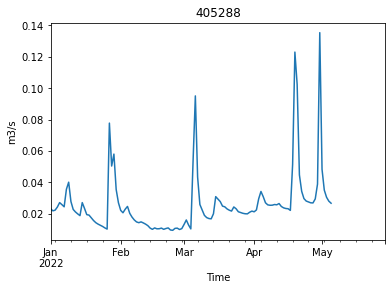

In [148]:
ts = make_daily_time_series(traces[0])
ts.plot(ylabel="m3/s", xlabel="Time", title = ts.name)

<AxesSubplot:title={'center':'405287'}, xlabel='Time', ylabel='m3/s'>

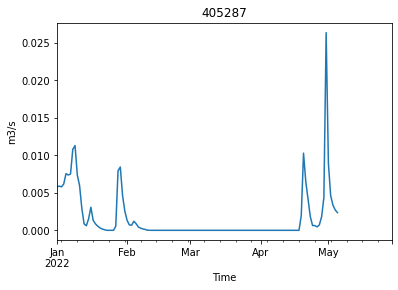

In [149]:
ts = make_daily_time_series(traces[1])
ts.plot(ylabel="m3/s", xlabel="Time", title = ts.name)


# Related resources

[Andrew Freebairn's python package 'bomwater'](https://github.com/csiro-hydroinformatics/pybomwater)
